## Import Library

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
from wordcloud import WordCloud
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.pipeline import Pipeline

plt.style.use('seaborn')

### Baca Dataset

In [2]:
df = pd.read_csv('../Datasets/spam.tsv', sep='\t')
df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1) # Drop kolom yang tidak digunakan
df.columns = ['label','email'] # Merubah nama kolom
df.email = df.email.apply(lambda e: e.lower().translate(str.maketrans('', '', string.punctuation)))
df

,label,email
0,ham,go until jurong point crazy available only in ...
1,ham,ok lar joking wif u oni
2,spam,free entry in 2 a wkly comp to win fa cup fina...
3,ham,u dun say so early hor u c already then say
4,ham,nah i dont think he goes to usf he lives aroun...
...,...,...
5567,spam,this is the 2nd time we have tried 2 contact u...
5568,ham,will � b going to esplanade fr home
5569,ham,pity was in mood for that soany other suggest...
5570,ham,the guy did some bitching but i acted like id ...


In [3]:
for spam in df[df.label=='spam'].iloc[:5].email:
    print(spam)
    print('*'*50)

free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005 text fa to 87121 to receive entry questionstd txt ratetcs apply 08452810075over18s
**************************************************
freemsg hey there darling its been 3 weeks now and no word back id like some fun you up for it still tb ok xxx std chgs to send �150 to rcv
**************************************************
winner as a valued network customer you have been selected to receivea �900 prize reward to claim call 09061701461 claim code kl341 valid 12 hours only
**************************************************
had your mobile 11 months or more u r entitled to update to the latest colour mobiles with camera for free call the mobile update co free on 08002986030
**************************************************
six chances to win cash from 100 to 20000 pounds txt csh11 and send to 87575 cost 150pday 6days 16 tsandcs apply reply hl 4 info
**************************************************


In [4]:
for ham in df[df.label=='ham'].iloc[:5].email:
    print(ham)
    print('*'*50)

go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat
**************************************************
ok lar joking wif u oni
**************************************************
u dun say so early hor u c already then say
**************************************************
nah i dont think he goes to usf he lives around here though
**************************************************
even my brother is not like to speak with me they treat me like aids patent
**************************************************


### Exploratory Data Analyst (EDA) Dataset

In [5]:
# Melihat jumlah data spam & ham
df['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

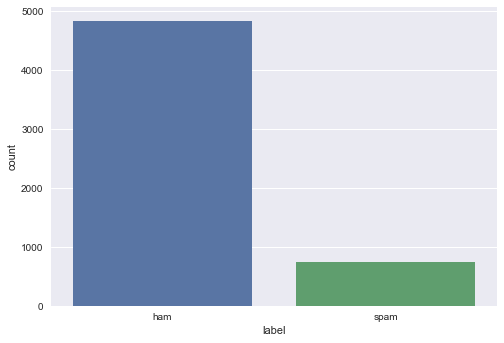

In [6]:
sns.countplot(x='label', data=df);

Nampak data label memiliki imbalace data, ini akan membuat hasil modeling menghasilkan hasil yang kurang tepat. Kita harus memperbaikinya.

In [7]:
# Check data missing value
df.isnull().sum()

label    0
email    0
dtype: int64

In [8]:
# Cek data duplikat
dupli = df[df.duplicated(subset=['email'])] # Cek data duplikat
df.drop_duplicates(subset=['email'], inplace=True) # Drop/membuang data duplikat
df

,label,email
0,ham,go until jurong point crazy available only in ...
1,ham,ok lar joking wif u oni
2,spam,free entry in 2 a wkly comp to win fa cup fina...
3,ham,u dun say so early hor u c already then say
4,ham,nah i dont think he goes to usf he lives aroun...
...,...,...
5567,spam,this is the 2nd time we have tried 2 contact u...
5568,ham,will � b going to esplanade fr home
5569,ham,pity was in mood for that soany other suggest...
5570,ham,the guy did some bitching but i acted like id ...


In [9]:
# Desribe dataset statiska deskriptif 
df.describe()

,label,email
count,5137,5137
unique,2,5137
top,ham,
freq,4500,1


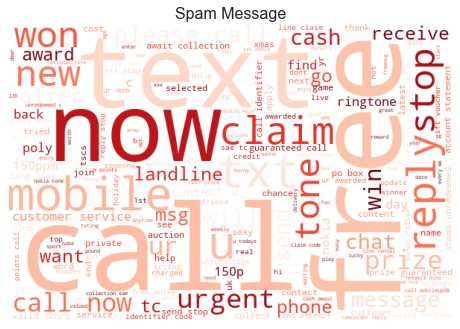

In [10]:
# Membuat WordCloud
data_spam = df[df['label'] == 'spam']
data_ham = df[df['label'] == 'ham']

def make_wc(data_spam_ham, title):
    text = ' '.join(data_spam_ham['email'].astype(str).tolist())
    spam_wc = WordCloud(max_font_size = 160, margin=0, width=600, height=400, background_color = "white", colormap="Reds").generate(text)
    plt.imshow(spam_wc)
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

make_wc(data_spam, 'Spam Message')

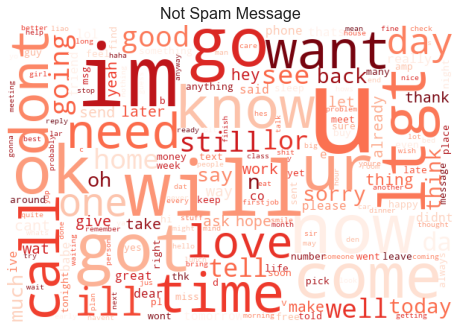

In [11]:
make_wc(data_ham, 'Not Spam Message')

### Data Preprocessing

In [12]:
# Merubah kolom label menjadi int 0 - 1
# Dan kolom label akan kita gunakan sebagai variabel dependent/target label
X = df['email'].values
y = df['label'].values

biner = LabelBinarizer()
y = biner.fit_transform(y).ravel()
df['target'] = y
print(y, '\n')
print(biner.classes_)

[0 0 1 ... 0 0 0] 

['ham' 'spam']


Ham 0
Spam 1

In [13]:
df.target.value_counts()

0    4500
1     637
Name: target, dtype: int64

In [14]:
df

,label,email,target
0,ham,go until jurong point crazy available only in ...,0
1,ham,ok lar joking wif u oni,0
2,spam,free entry in 2 a wkly comp to win fa cup fina...,1
3,ham,u dun say so early hor u c already then say,0
4,ham,nah i dont think he goes to usf he lives aroun...,0
...,...,...,...
5567,spam,this is the 2nd time we have tried 2 contact u...,1
5568,ham,will � b going to esplanade fr home,0
5569,ham,pity was in mood for that soany other suggest...,0
5570,ham,the guy did some bitching but i acted like id ...,0


### Processing text

In [72]:
X = df['email'].values
y = df['target'].values
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

# Tokenizing
vec = CountVectorizer()
X_train_vec = vec.fit_transform(X)
# X_train_vec.shape

# Tf transformer
tf_trans = TfidfTransformer()
X_train_idf = tf_trans.fit_transform(X_train_vec)
# X_train_idf.shape

# docs_new = ['urgent call this number', 'hello dita how are you']
X_test = vec.transform(X)
X_test_idf = tf_trans.transform(X_test)

### Model Building

In [74]:
df.head(10)

,label,email,target
0,ham,go until jurong point crazy available only in ...,0
1,ham,ok lar joking wif u oni,0
2,spam,free entry in 2 a wkly comp to win fa cup fina...,1
3,ham,u dun say so early hor u c already then say,0
4,ham,nah i dont think he goes to usf he lives aroun...,0
5,spam,freemsg hey there darling its been 3 weeks now...,1
6,ham,even my brother is not like to speak with me t...,0
7,ham,as per your request melle melle oru minnaminun...,0
8,spam,winner as a valued network customer you have b...,1
9,spam,had your mobile 11 months or more u r entitled...,1


[0 0 1 0 0 0 0 0 1 1] 

Accuracy Score: 0.9700214132762313 

Classification Report: 
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      4500
           1       0.99      0.76      0.86       637

    accuracy                           0.97      5137
   macro avg       0.98      0.88      0.92      5137
weighted avg       0.97      0.97      0.97      5137
 

Confusion Matrix: 
[[4496    4]
 [ 150  487]] 



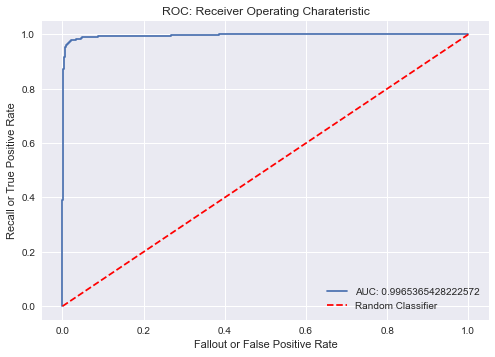

In [87]:
# LogisticRegression
model_lr = LogisticRegression().fit(X_train_idf, y)
prediction = model_lr.predict(X_test_idf)
print(prediction[:10], '\n')
acc_lr = (prediction == y).mean()
print(f'Accuracy Score: {acc_lr}', '\n')
print(f'Classification Report: \n{classification_report(y, prediction)}', '\n')
print(f'Confusion Matrix: \n{confusion_matrix(y, prediction)}', '\n')

prob_estimates = model_lr.predict_proba(X_test_idf)
fpr, tpr, threshold = roc_curve(y, prob_estimates[:, 1])
nilai_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'AUC: {nilai_auc}')
plt.plot([0,1], [0,1], 'r--', label='Random Classifier')
plt.title('ROC: Receiver Operating Charateristic')
plt.ylabel('Recall or True Positive Rate')
plt.xlabel('Fallout or False Positive Rate')
plt.legend()
plt.show()

[0 0 1 0 0 1 0 0 1 1] 

Accuracy Score: 1.0 

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4500
           1       1.00      1.00      1.00       637

    accuracy                           1.00      5137
   macro avg       1.00      1.00      1.00      5137
weighted avg       1.00      1.00      1.00      5137
 

Confusion Matrix: 
[[4500    0]
 [   0  637]] 



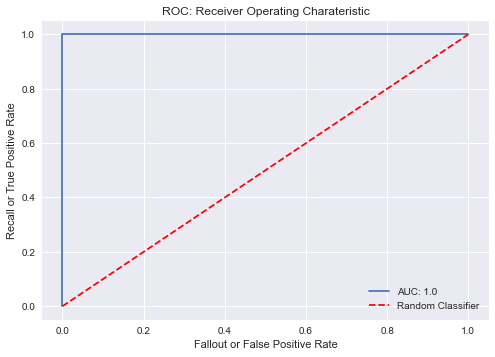

In [92]:
# RandomForestClassifier
model_rfc = RandomForestClassifier(n_estimators=110).fit(X_train_idf, y)
prediction = model_rfc.predict(X_test_idf)
print(prediction[:10], '\n')
acc_rfc = (prediction == y).mean()
print(f'Accuracy Score: {acc_rfc}', '\n')
print(f'Classification Report: \n{classification_report(y, prediction)}', '\n')
print(f'Confusion Matrix: \n{confusion_matrix(y, prediction)}', '\n')

prob_estimates = model_rfc.predict_proba(X_test_idf)
fpr, tpr, threshold = roc_curve(y, prob_estimates[:, 1])
nilai_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'AUC: {nilai_auc}')
plt.plot([0,1], [0,1], 'r--', label='Random Classifier')
plt.title('ROC: Receiver Operating Charateristic')
plt.ylabel('Recall or True Positive Rate')
plt.xlabel('Fallout or False Positive Rate')
plt.legend()
plt.show()

[0 0 1 0 0 1 0 0 1 1] 

Accuracy Score: 1.0 

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4500
           1       1.00      1.00      1.00       637

    accuracy                           1.00      5137
   macro avg       1.00      1.00      1.00      5137
weighted avg       1.00      1.00      1.00      5137
 

Confusion Matrix: 
[[4500    0]
 [   0  637]] 



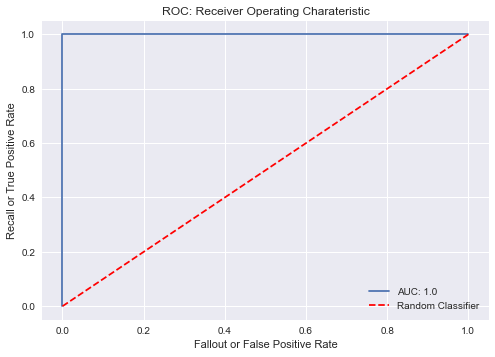

In [93]:
# DecisionTreeClassifier
model_dtc = DecisionTreeClassifier().fit(X_train_idf, y)
prediction = model_dtc.predict(X_test_idf)
print(prediction[:10], '\n')
acc_dtc = (prediction == y).mean()
print(f'Accuracy Score: {acc_dtc}', '\n')
print(f'Classification Report: \n{classification_report(y, prediction)}', '\n')
print(f'Confusion Matrix: \n{confusion_matrix(y, prediction)}', '\n')

prob_estimates = model_dtc.predict_proba(X_test_idf)
fpr, tpr, threshold = roc_curve(y, prob_estimates[:, 1])
nilai_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'AUC: {nilai_auc}')
plt.plot([0,1], [0,1], 'r--', label='Random Classifier')
plt.title('ROC: Receiver Operating Charateristic')
plt.ylabel('Recall or True Positive Rate')
plt.xlabel('Fallout or False Positive Rate')
plt.legend()
plt.show()

[0 0 1 0 0 1 0 0 1 1] 

Accuracy Score: 0.9976640062293167 

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4500
           1       1.00      0.98      0.99       637

    accuracy                           1.00      5137
   macro avg       1.00      0.99      0.99      5137
weighted avg       1.00      1.00      1.00      5137
 

Confusion Matrix: 
[[4500    0]
 [  12  625]] 



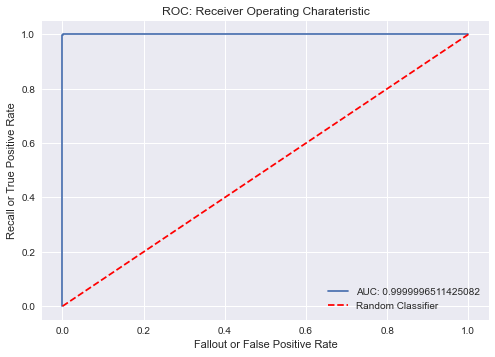

In [95]:
# SVC
model_svc = SVC(random_state=0, probability=True).fit(X_train_idf, y)
prediction = model_svc.predict(X_test_idf)
print(prediction[:10], '\n')
acc_svc = (prediction == y).mean()
print(f'Accuracy Score: {acc_svc}', '\n')
print(f'Classification Report: \n{classification_report(y, prediction)}', '\n')
print(f'Confusion Matrix: \n{confusion_matrix(y, prediction)}', '\n')

prob_estimates = model_svc.predict_proba(X_test_idf)
fpr, tpr, threshold = roc_curve(y, prob_estimates[:, 1])
nilai_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'AUC: {nilai_auc}')
plt.plot([0,1], [0,1], 'r--', label='Random Classifier')
plt.title('ROC: Receiver Operating Charateristic')
plt.ylabel('Recall or True Positive Rate')
plt.xlabel('Fallout or False Positive Rate')
plt.legend()
plt.show()

[0 0 0 0 0 0 0 0 0 1] 

Accuracy Score: 0.9215495425345532 

Classification Report: 
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      4500
           1       1.00      0.37      0.54       637

    accuracy                           0.92      5137
   macro avg       0.96      0.68      0.75      5137
weighted avg       0.93      0.92      0.91      5137
 

Confusion Matrix: 
[[4500    0]
 [ 403  234]] 



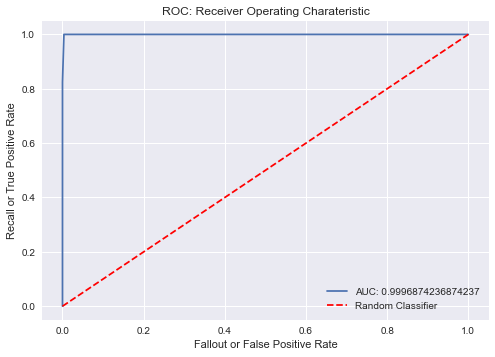

In [96]:
# KNeighborsClassifier
model_knn = KNeighborsClassifier(n_neighbors=5).fit(X_train_idf, y)
prediction = model_knn.predict(X_test_idf)
print(prediction[:10], '\n')
acc_knn = (prediction == y).mean()
print(f'Accuracy Score: {acc_knn}', '\n')
print(f'Classification Report: \n{classification_report(y, prediction)}', '\n')
print(f'Confusion Matrix: \n{confusion_matrix(y, prediction)}', '\n')

prob_estimates = model_knn.predict_proba(X_test_idf)
fpr, tpr, threshold = roc_curve(y, prob_estimates[:, 1])
nilai_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'AUC: {nilai_auc}')
plt.plot([0,1], [0,1], 'r--', label='Random Classifier')
plt.title('ROC: Receiver Operating Charateristic')
plt.ylabel('Recall or True Positive Rate')
plt.xlabel('Fallout or False Positive Rate')
plt.legend()
plt.show()

### Predict with New Data

In [78]:
emails = [
    'URGENT your grandson was arrested ast night in Mexico. Need bail money immediately Western Union Wire $9,500 http://goo.gl/mdf5543',
    'Conratulations! You\'ve won a $1,000 Walmart gift card. Go to http://bit.ly/123456 to claim now.',
    'Hello mia, whatsup',
    'urgent call this number', 
    'hello dita how are you'
]

emails = pd.DataFrame(emails, columns=['data'])
emails.data = emails.data.apply(lambda e: e.lower().translate(str.maketrans('', '', string.punctuation)))
emails

,data
0,urgent your grandson was arrested ast night in...
1,conratulations youve won a 1000 walmart gift c...
2,hello mia whatsup
3,urgent call this number
4,hello dita how are you


In [79]:
new_data = vec.transform(emails.data.values)
new_data_tfidf = tf_trans.transform(new_data)
predicted = clf.predict(new_data_tfidf) # Menggunakan LogisticRegression
predicted

array([0, 1, 0, 1, 0])

### Mencari Best Model & Best Parameters Using RandomizedSearchCV